In [1]:
## Enviroment Setup
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Set the visible CUDA, here we use the second GPU
WORKING_DIR = '/home/peizhi/Documents/gaussian-dejavu/'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())
sys.path.append(WORKING_DIR)
sys.path.append('./models')
sys.path.append('./networks')
sys.path.append('./utils')
sys.path.append('./utils/flame_lib/')
sys.path.append('./utils/diff-gaussian-rasterization')
sys.path.append('./utils/gaussian_renderer')
sys.path.append('./utils/scene')
sys.path.append('./utils/arguments')
sys.path.append('./utils/simple-knn')

import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import numpy as np
import cv2
import torch

from dejavu import GaussianDejavu
from utils.personal_video_utils import *

def min_max_normalize(image):
    norm_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return norm_image

dejavu = GaussianDejavu(network_weights='./models/dejavu_network.pt', uv_map_size=320, num_expressions=10)
device = dejavu.device




Current Working Directory:  /home/peizhi/Documents/gaussian-dejavu
creating the FLAME Decoder


/home/peizhi/Documents/gaussian-dejavu/utils/flame_lib/FLAME.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_faces_idx', torch.tensor(lmk_embeddings['dynamic_lmk_faces_idx'], dtype=torch.long))
/home/peizhi/Documents/gaussian-dejavu/utils/flame_lib/FLAME.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_bary_coords', torch.tensor(lmk_embeddings['dynamic_lmk_bary_coords'], dtype=self.dtype))
/home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./models/head_template2.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


Framework v3.1 initialized.
Number of Gaussians:  74083
model loaded from:  ./models/dejavu_network.pt
Gaussian DejaVu Framework Created.


## Personal Data Loader

Number of frames: 3131.
img torch.Size([3, 512, 512, 3])
parsing (3, 512, 512)
vertices (3, 5023, 3)
shape torch.Size([3, 100])
exp torch.Size([3, 50])
pose torch.Size([3, 6])
eye_pose torch.Size([3, 6])
tex torch.Size([3, 50])
light torch.Size([3, 9, 3])
cam torch.Size([3, 6])
img_masked torch.Size([3, 512, 512, 3])
masks torch.Size([3, 512, 512, 1])


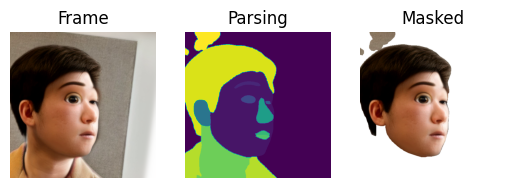

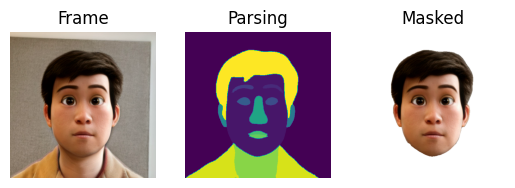

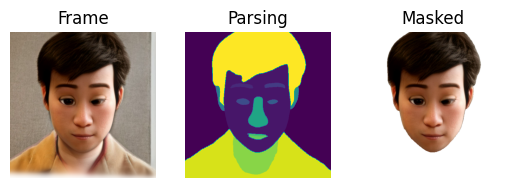

In [2]:
# First, follow the vToonify to stylize the video
# https://github.com/williamyang1991/VToonify

# Then, follow the flame-head-tracker to reconstruct the FLAME parameters  
# https://github.com/PeizhiYan/flame-head-tracker


dataset_path = '/mnt/data3_hdd/peizhi/Datasets/Personal_Videos_flame_new/peizhi-cartoon'
personal_dataloader = PersonalDataLoader(dataset_path=dataset_path, device=device, shuffle=True)

batch_data = personal_dataloader.next_random_batch(batch_size=3)

for key in batch_data:
    try:
        print(key, batch_data[key].shape)
    except:
        pass

for i in range(len(batch_data['fid'])):    
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(batch_data['img'][i].detach().cpu()); plt.axis('off'); plt.title('Frame')
    plt.subplot(1,3,2)
    plt.imshow(batch_data['parsing'][i]); plt.axis('off'); plt.title('Parsing')
    plt.subplot(1,3,3)
    plt.imshow(batch_data['img_masked'][i].detach().cpu()); plt.axis('off'); plt.title('Masked')
    plt.show()



## Train

In [ ]:
dejavu.personal_video_training(personal_dataloader, batch_size=16, stage_1_steps=500, stage_2_steps=1000)



/home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Compare Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

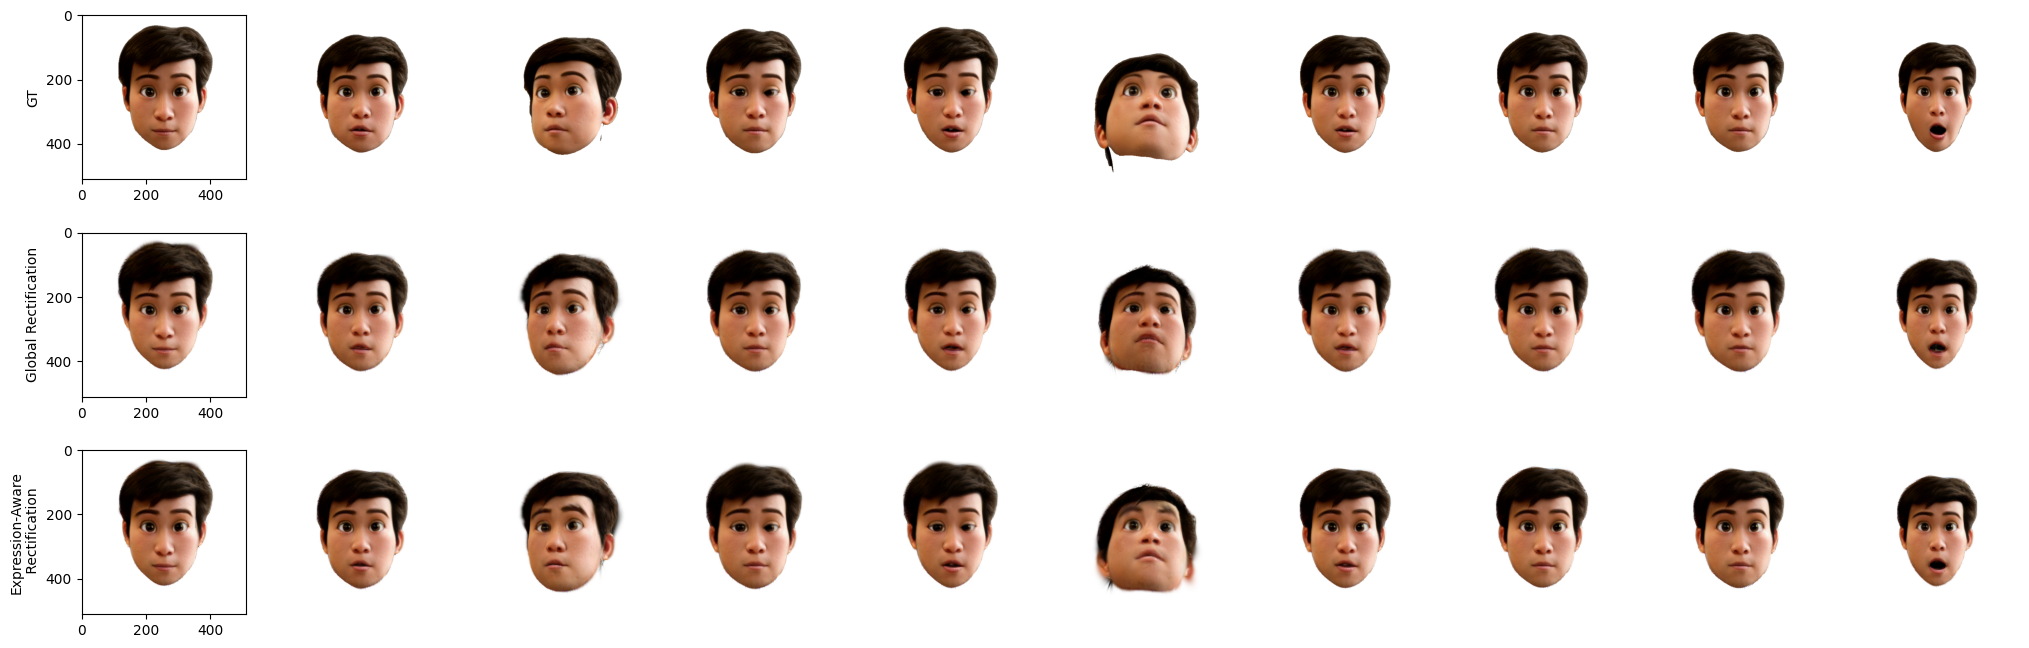

In [4]:

plt.figure(figsize=(25,8))

num_examples = 10
for i in range(num_examples):
    batch_data_test = personal_dataloader.next_random_batch(vid=None, batch_size=1)

    # Ground-Truth Frames (First Row)
    plt.subplot(3,num_examples,i+1)
    plt.imshow(batch_data_test['img_masked'][0].detach().cpu()); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('GT')

    # Reconstructed, w/ Global Rectification (Second Row)
    plt.subplot(3,num_examples,num_examples+i+1)
    batch_rendered_global = dejavu._render_with_global_offsets_(batch_data_test, dejavu.global_uv_delta)
    plt.imshow(batch_rendered_global[0].detach().cpu().permute(1,2,0)); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('Global Rectification')

    # Reconstructed, w/ Expression-Aware Rectification (Third Row)
    plt.subplot(3,num_examples,2*num_examples+i+1)
    batch_rendered_blend, _ = dejavu._render_with_blendmaps_(batch_data_test, dejavu.uv_delta_blendmaps)
    plt.imshow(batch_rendered_blend[0].detach().cpu().permute(1,2,0)); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('Expression-Aware\n Rectification')

plt.show()



## Save Head Avatar

In [5]:
## save head avatar

dejavu.save_head_avatar(save_path='./saved_avatars', avatar_name='peizhi-cartoon-uv120')



Head avatar parameters saved to ./saved_avatars/peizhi-cartoon-uv120


## Load Head Avatar

In [6]:
## load head avatar

dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='peizhi-cartoon-uv120')


Head avatar parameters loaded
